# INFO-F-208 - Projet 2 -- Alexandre Heneffe -- 09/11/2018
Ce document "jupyter notebook" nous introduit et nous décrit les différents algorithmes implémentés dans le cadre du Mini Projet 2 du cours "Introduction à la bioinformatique"

## Introduction

Dans le cadre du projet précédent, nous avons du implémenter des algorithmes permettant d'aligner des paires de séquences d'acides aminés. Malheureusement, ces alignements ne sont pas toujours les meilleurs et permettaient seulement de constater les similitudes entre 2 séquences. De plus, nous ne pouvions pas trouver un domaine BRD spécifique à l'aide de ces alignements.

Un moyen pour améliorer la qualité de ces alignements est d'aligner plusieurs séquences. Nous allons ensuite représenter ces alignements multiples sous forme d'une matrice "PSSM" (Position Specitif Scoring Matrices), ou plus communément appelée "Profil". Nous y mettrons les probabilités d'apparition des acides aminés dans une position spécifique. Ceci sera détaillé plus loin.

Notre but final est d'adapter nos algorithmes d'alignement de séquences vers un système qui peut aligner des séquences de protéines à des profils. Ces matrices vont résumer de manière compacte un alignement de séquences multiple en utilisant les probabilités d'apparition des acides aminés dans une certaine position. Ici, nous utiliserons un PSSM du domaine BRD.

Un domaine protéique est une partie d'une protéine capable d'adopter une structure de manière autonome ou partiellement autonome du reste de la molécule. Les domaines évoluent au cours du temps selon des mutations génétiques acceptées ou non par l'évolution. Ils ont ainsi plusieurs formes et ne sont pas toujours exacts.

Un domaine protéique est généralement caractérisé par sa structure tridimensionnelle et par des acides aminés. Un même domaine peut figurer dans plusieurs protéines ayant une variété de fonctionnalités. Cette modularité permet de construire une grande variété de protéines.

Ici, nous travaillons avec les Bromo Domaines (Les bromodomaines sont des modules interactifs reconnaissant les sites d'acétylation (réactions chimiques) dans les protéines. Les BRD sont notamment intéressantes pour développer de nouvelles thérapies pour le cancer humain ou pour la sclérose en plaques par exemple.). 

Le fait d'aligner des séquences protéines à ces PSSM représentant des bromo domaines, nous permettra d'identifier si celles-ci contiennent ces bromo domaines.

In [1]:
import copy as c
import math
import pandas as p
import time

p.set_option('display.max_columns', 500)                    # Maximum 500 colonnes affichées
p.options.display.float_format = '{:,.3f}'.format           # Affiche les chiffres en float avec 3 chiffres apres 
                                                            # la virgule

Nous importons les ADT créées dans la partie précédentes du projet et que nous n'avons pas modifié pour cette partie (Sequence, ParserSequence, Matrix, MatSubstitution, MatScoring, MatV, MatW ) 

In [2]:
import other_ADT as o

Ci-dessous, nous avons l'objet Alignement, qui représente donc un alignement de manière générale et dont la méthodologie a été modifiée quelque peu pour l'alignement local à un profil (les modifications ainsi que ceci seront décrits plus loin).

In [3]:
class Alignment:
    """ Classe représentant un objet qui trouvera l'alignement de 2 séquences
        d'acides aminées
    """

    def __init__(self, I, E, mat_file, seq1, seq2, p, prof=None):
        
        self.I = I 
        self.E = E
        self.p = p
        self.seq1 = seq1
        self.seq2 = seq2
        self.n = self.seq1.length()+1
        self.m = self.seq2.length()+1

        if p == 2: # Si on veut imprimer les informations
            print("Séquence 1 de longueur {0}: ".format(self.n))
            self.seq1.display()
            print("Séquence 2 de longueur {0}: ".format(self.m))
            self.seq2.display()
            print("matrice de substitution utilisée: {0}".format(mat_file))
            print("Pénalité de gap : I = {0} | E = {1}".format(self.I, self.E))

        # =================== SUBSITUTION ==============================
        self.t = o.MatSubstitution(mat_file)
        self.t.parse()

        # =================== SCORING ===============================

        self.S = o.MatScoring(I, E, self.n, self.m) # Création matrice scoring

        # ===================== V ET W ===================================

        self.V = o.MatV(self.n, self.m)
        self.W = o.MatW(self.n, self.m)

        self.V.init_V() # Initialise V
        self.W.init_W() # Initialise W
        self.V.setup_seq("-"+self.seq1.get_acids(), "-"+self.seq2.get_acids())
        self.W.setup_seq("-"+self.seq1.get_acids(), "-"+self.seq2.get_acids())

        self.current_sol = [] # Pour le backtracking
        self.all_solutions = []
        
        self.prof = prof # Si on veut aligner avec une matrice PROFIL

    def get_v(self, i, j):
        return max(self.S.get_score(i-1, j)-self.I,self.V.get_score(i-1,j)-self.E)

    def get_w(self, i, j):
        return max(self.S.get_score(i, j-1)-self.I,self.W.get_score(i, j-1)-self.E)

Ci-dessous se trouve la classe représentant un alignement global. Celui-ci ne diffère pas de la partie précédente. De ce fait, aucune explication ne sera faite à ce sujet.

In [4]:
class GlobalAlignment(Alignment):
    """
    Classe qui va trouver un aligement de séquences d'acides aminées avec
    une pénalité affine et une méthode globale
    """

    def __init__(self, k, I, E, mat_file, seq1, seq2, p, prof=None):
        Alignment.__init__(self, I, E, mat_file, seq1, seq2, p, prof)
        self.k = k

        self.S.init_S_global()  # On initialise la matrice de scoring
        self.S.setup_seq("-"+self.seq1.get_acids(), "-"+self.seq2.get_acids())

    def get_s_global(self, i, j, v_ij, w_ij):
        letters_ij = self.S.get_letters(i,j) # 'AB' par exemple
        t_ij = self.t.get_acid_score(letters_ij[0], letters_ij[1])

        s_ij = max( self.S.get_score(i-1,j-1) + t_ij, v_ij, w_ij )
        # self.S.set_score(i,j, s_ij)

        return s_ij

    def Needleman_Wunsch(self):
        """ 
        Algorithme qui calcule la matrice de scoring pour l’alignement global 
        en utilisant la pénalité affine puis fait un backtracking pour récupérer
        tous les alignements optimaux possibles
        """

        # ==================== CREATION SCORING ===========================

        for i in range(1, self.m):
            for j in range(1, self.n):
                v_ij = self.get_v(i, j)   # V(i,j)
                self.V.set_score(i,j, v_ij)
                w_ij = self.get_w(i, j)
                self.W.set_score(i,j, w_ij) # W(i,j)
                s_ij = self.get_s_global(i, j, v_ij, w_ij)
                self.S.set_score(i, j, s_ij) # S(i,j)

        if self.p == 2: # Si on veut afficher les matrices
            self.V.panda()
            self.W.panda()
            self.S.panda()

        self.bottom_up(self.m-1, self.n-1)

        R = Result(self.all_solutions, self.p)
        return R.bind()

    def bottom_up(self, i,j):
        """ 
        Remonte la matrice de scoring du dernier élément vers l'élement (0,0) 
        pour construire l'alignement 
        """
        while not (i == 0 or j == 0):
            prev_i = i
            prev_j = j
            pos = 2
            if self.is_previous("v", i, j):    # haut
                i-=1
                pos = 0
            elif self.is_previous("w", i, j):  # gauche
                j-=1
                pos = 1
            elif self.is_previous("s", i, j):  # diagonale
                i-=1
                j-=1
            self.add_sol(prev_i,prev_j,pos, self.prof != None)

        if not (i == 0 and j == 0):
            self.add_sol(i, j, 2, self.prof != None)
        self.all_solutions.append(self.current_sol)


## Matériel 

Nous disposons de différents "dataset" (ensemble de données) permettant d'analyser des séquences: 

### Smart
Le site "Smart" possède une base de données qui répertorie un grand nombre de séquences. Ceux qui nous intéressent sont les séquences qui représentent la famille Bromo. Il y a 14324 domaines du type Bromo. Nous choisissons les 223 séquences liées aux domaines Bromo des protéines humaines. 

- Eukaryotes
    - Metazoa
        - Chordata
            - Mammalia
                - Primates
                    - Hominidae
                        - Homo
                            - Homo Sapiens


### Réduit
Certaines séquences parmi les 223 séquences du domaine Bromo de type humain sont trop similaires (certaines séquences sont identiques, mais avec des noms différents). Les séquences trop similaires vont biaiser nos résultats (la construction du profil qui doit tenir compte que d'un domaine bromodomaine spécifique). En effet, si il y a un grand nombre de séquences similaires, il se peut qu'il y ait d'autres domaines que celui que l'on cherche à synthétiser. De ce fait, nous créons un autre ensemble de séquences dont le score de similarité maximal entre eux est de 60%.

Pour retirer les séquences qui induisent un score de similarité de plus de 60%, nous avons procédé ainsi:

- Nous créons un groupe
- Pour chaque séquence de l'ensemble contenu dans le fichier to-be-aligned.fasta, nous la comparons à toutes les séquences présentes dans le groupe (initialement le premier élément). 
    - Si cette séquence est similaire à 60% aux séquences du groupe, nous l'ajoutons dans celui-ci.
    - Sinon, nous ne l'ajoutons pas
    
Ceci est réalisé par le code ci-dessous

In [5]:
def is_very_similar(S, I, E, seq):
    """
    Regarde si une séquence est similaire a toutes les autres séquences
    """

    for j in range(len(S)):
        if S[j].get_acids() == seq.get_acids():
            return True 
        G_tmp = GlobalAlignment(1, I, E, "pam60.txt", S[j], seq, 0) # alignement global
        tmp_score = G_tmp.Needleman_Wunsch()
        if tmp_score[0] > 60:
            return True 
        
    return False

def remove_high_scores(S, I, E):
    # S = liste de séquences
    reduced = [S[0]]
    for i in range(1, len(S)):
        if not is_very_similar(reduced, I, E, S[i]):
            reduced.append(S[i])

    reduced_file = open("reduced_pam60.fasta", "w")  # Nous mettons les séquences dans un fichier
    for s in reduced:
        reduced_file.write(s.get_title())
        reduced_file.write(s.get_acids()+"\n")
    reduced_file.close()

Cependant, la détermination de ces séquences est biaisée par 2 facteurs:

- L'ordre dans lequel les séquences sont placées dans la liste privilégie les premiers choisis.
- Lorsque nous vérifions la similarité entre 2 séquences durant le processus, nous prenons le premier alignement global et pas l'alignement optimal (avec backtracking), 

Au niveau des paramètres, nous utilisons la matrice de substitution pam60 car nous obtenons plus de séquences (34) qu'avec les matrices blosum62 (20) et blosum80 (25). La matrice Pam60 contient plus de valeurs négatives que pam120 et donc moins de valeurs positives représentant des mutations génétiques acceptées par l'évolution. De ce fait, les séquences alignées à l'aide de la matrice pam60 seront moins similaires. 

De plus, nous utilisons une pénalité linéaire de 2 car celle-ci va favoriser l'apparition de d'avantage de "gap" et donc induire une similarité moins élevée et donc plus de séquences dans la liste des "réduits".

Au final, nous obtenons un fichier avec une série de séquences ayant moins de 60% de similarité entre elles.

### MSA

Les séquences recueillies sur le site Smart (les 223 séquences du domaine Bromo de type humain) vont être alignées à l'aide de l'outil MUSCLE.

Cet outil va procéder à un MSA (Multiple Sequence Alignment), c'est-à-dire un alignement de séquences multiple. Celui-ci va introduire beaucoup de gap (Espace signifiant qu'un acide aminé ne reste pas ou ne se transforme pas au cours de l'évolution), ce qui permettra d'avoir des séquences ayant des parties similaires et de ce fait un PSSM cohérent représentant un domaine BRD.

#### Outil

Comme le suggère Wikipedia, l'algorithme MUSCLE procède en 3 étapes: 
- Un alignement progressif créant un arbre
- une amélioration de cet alignement progressif se basant sur l'arbre créé 
- une étape de raffinement itératif. 

Il met en avant la rapidité plutot que la précision. 

Sans raffinement, la précision moyenne de MUSCLE est statistiquement impossible à distinguer de celle de T-Coffee ou CLUSTAL. Mais MUSCLE est l'algorithme le plus rapide. Il peut aligner 5000 séquences d'une longueur moyenne de 350 en 7 minutes. Voilà pourquoi nous avons opté pour cet outil.

Nous alignons également les séquences réduites (moins de 60% de similarité) avec le même outil "MUSCLE".

### Protéines

Nous disposons également de 2 grosses séquences protéiques qui serons alignées aux profils afin de déterminer si elles contiennent un bromodomaine représenté par le profil.

>sp|P21675|TAF1_HUMAN Transcription initiation factor TFIID subunit 1 OS=Homo sapiens OX=9606 GN=TAF1 PE=1 SV=2
MGPGCDLLLRTAATITAAAIMSDTDSDEDSAGGGPFSLAGFLFGNINGAGQLEGESVLDDECKKHLAGLGALGLGSLITELTANEELTGTDGALVNDEGWVRSTEDAVDYSDINEVAEDESRRYQQTMGSLQPLCHSDYDEDDYDADCEDIDCKLMPPPPPPPGPMKKDKDQDSITGEKVDFSSSSDSESEMGPQEATQAESEDGKLTLPLAGIMQHDATKLLPSVTELFPEFRPGKVLRFLRLFGPGKNVPSVWRSARRKRKKKHRELIQEEQIQEVECSVESEVSQKSLWNYDYAPPPPPEQCLSDDEITMMAPVESKFSQSTGDIDKVTDTKPRVAEWRYGPARLWYDMLGVPEDGSGFDYGFKLRKTEHEPVIKSRMIEEFRKLEENNGTDLLADENFLMVTQLHWEDDIIWDGEDVKHKGTKPQRASLAGWLPSSMTRNAMAYNVQQGFAATLDDDKPWYSIFPIDNEDLVYGRWEDNIIWDAQAMPRLLEPPVLTLDPNDENLILEIPDEKEEATSNSPSKESKKESSLKKSRILLGKTGVIKEEPQQNMSQPEVKDPWNLSNDEYYYPKQQGLRGTFGGNIIQHSIPAVELRQPFFPTHMGPIKLRQFHRPPLKKYSFGALSQPGPHSVQPLLKHIKKKAKMREQERQASGGGEMFFMRTPQDLTGKDGDLILAEYSEENGPLMMQVGMATKIKNYYKRKPGKDPGAPDCKYGETVYCHTSPFLGSLHPGQLLQAFENNLFRAPIYLHKMPETDFLIIRTRQGYYIRELVDIFVVGQQCPLFEVPGPNSKRANTHIRDFLQVFIYRLFWKSKDRPRRIRMEDIKKAFPSHSESSIRKRLKLCADFKRTGMDSNWWVLKSDFRLPTEEEIRAMVSPEQCCAYYSMIAAEQRLKDAGYGEKSFFAPEEENEEDFQMKIDDEVRTAPWNTTRAFIAAMKGKCLLEVTGVADPTGCGEGFSYVKIPNKPTQQKDDKEPQPVKKTVTGTDADLRRLSLKNAKQLLRKFGVPEEEIKKLSRWEVIDVVRTMSTEQARSGEGPMSKFARGSRFSVAEHQERYKEECQRIFDLQNKVLSSTEVLSTDTDSSSAEDSDFEEMGKNIENMLQNKKTSSQLSREREEQERKELQRMLLAAGSAASGNNHRDDDTASVTSLNSSATGRCLKIYRTFRDEEGKEYVRCETVRKPAVIDAYVRIRTTKDEEFIRKFALFDEQHREEMRKERRRIQEQLRRLKRNQEKEKLKGPPEKKPKKMKERPDLKLKCGACGAIGHMRTNKFCPLYYQTNAPPSNPVAMTEEQEEELEKTVIHNDNEELIKVEGTKIVLGKQLIESADEVRRKSLVLKFPKQQLPPKKKRRVGTTVHCDYLNRPHKSIHRRRTDPMVTLSSILESIINDMRDLPNTYPFHTPVNAKVVKDYYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVKNSATYNGPKHSLTQISQSMLDLCDEKLKEKEDKLARLEKAINPLLDDDDQVAFSFILDNIVTQKMMAVPDSWPFHHPVNKKFVPDYYKVIVNPMDLETIRKNISKHKYQSRESFLDDVNLILANSVKYNGPESQYTKTAQEIVNVCYQTLTEYDEHLTQLEKDICTAKEAALEEAELESLDPMTPGPYTPQPPDLYDTNTSLSMSRDASVFQDESNMSVLDIPSATPEKQVTQEGEDGDGDLADEEEGTVQQPQASVLYEDLLMSEGEDDEEDAGSDEEGDNPFSAIQLSESGSDSDVGSGGIRPKQPRMLQENTRMDMENEESMMSYEGDGGEASHGLEDSNISYGSYEEPDPKSNTQDTSFSSIGGYEVSEEEEDEEEEEQRSGPSVLSQVHLSEDEEDSEDFHSIAGDSDLDSDE

- Proteine: Transcription initiation factor TFIID subunit 1
- Gène: TAF1

Nous savons, d'après le site uniprot, que cette séquence contient 2 sous-séquences représentant des domaines BRD:

Dans les intervalles:

- Bromo1: [1397 – 1467]
- Bromo2: [1520 – 1590]

>sp|Q86U86|PB1_HUMAN Protein polybromo-1 OS=Homo sapiens OX=9606 GN=PBRM1 PE=1 SV=1
MGSKRRRATSPSSSVSGDFDDGHHSVSTPGPSRKRRRLSNLPTVDPIAVCHELYNTIRDYKDEQGRLLCELFIRAPKRRNQPDYYEVVSQPIDLMKIQQKLKMEEYDDVNLLTADFQLLFNNAKSYYKPDSPEYKAACKLWDLYLRTRNEFVQKGEADDEDDDEDGQDNQGTVTEGSSPAYLKEILEQLLEAIVVATNPSGRLISELFQKLPSKVQYPDYYAIIKEPIDLKTIAQRIQNGSYKSIHAMAKDIDLLAKNAKTYNEPGSQVFKDANSIKKIFYMKKAEIEHHEMAKSSLRMRTPSNLAAARLTGPSHSKGSLGEERNPTSKYYRNKRAVQGGRLSAITMALQYGSESEEDAALAAARYEEGESEAESITSFMDVSNPFYQLYDTVRSCRNNQGQLIAEPFYHLPSKKKYPDYYQQIKMPISLQQIRTKLKNQEYETLDHLECDLNLMFENAKRYNVPNSAIYKRVLKLQQVMQAKKKELARRDDIEDGDSMISSATSDTGSAKRKSKKNIRKQRMKILFNVVLEAREPGSGRRLCDLFMVKPSKKDYPDYYKIILEPMDLKIIEHNIRNDKYAGEEGMIEDMKLMFRNARHYNEEGSQVYNDAHILEKLLKEKRKELGPLPDDDDMASPKLKLSRKSGISPKKSKYMTPMQQKLNEVYEAVKNYTDKRGRRLSAIFLRLPSRSELPDYYLTIKKPMDMEKIRSHMMANKYQDIDSMVEDFVMMFNNACTYNEPESLIYKDALVLHKVLLETRRDLEGDEDSHVPNVTLLIQELIHNLFVSVMSHQDDEGRCYSDSLAEIPAVDPNFPNKPPLTFDIIRKNVENNRYRRLDLFQEHMFEVLERARRMNRTDSEIYEDAVELQQFFIKIRDELCKNGEILLSPALSYTTKHLHNDVEKERKEKLPKEIEEDKLKREEEKREAEKSEDSSGAAGLSGLHRTYSQDCSFKNSMYHVGDYVYVEPAEANLQPHIVCIERLWEDSAGEKWLYGCWFYRPNETFHLATRKFLEKEVFKSDYYNKVPVSKILGKCVVMFVKEYFKLCPENFRDEDVFVCESRYSAKTKSFKKIKLWTMPISSVRFVPRDVPLPVVRVASVFANADKGDDEKNTDNSEDSRAEDNFNLEKEKEDVPVEMSNGEPGCHYFEQLHYNDMWLKVGDCVFIKSHGLVRPRVGRIEKVWVRDGAAYFYGPIFIHPEETEHEPTKMFYKKEVFLSNLEETCPMTCILGKCAVLSFKDFLSCRPTEIPENDILLCESRYNESDKQMKKFKGLKRFSLSAKVVDDEIYYFRKPIVPQKEPSPLLEKKIQLLEAKFAELEGGDDDIEEMGEEDSEVIEPPSLPQLQTPLASELDLMPYTPPQSTPKSAKGSAKKEGSKRKINMSGYILFSSEMRAVIKAQHPDYSFGELSRLVGTEWRNLETAKKAEYEERAAKVAEQQERERAAQQQQPSASPRAGTPVGALMGVVPPPTPMGMLNQQLTPVAGMMGGYPPGLPPLQGPVDGLVSMGSMQPLHPGGPPPHHLPPGVPGLPGIPPPGVMNQGVAPMVGTPAPGGSPYGQQVGVLGPPGQQAPPPYPGPHPAGPPVIQQPTTPMFVAPPPKTQRLLHSEAYLKYIEGLSAESNSISKWDQTLAARRRDVHLSKEQESRLPSHWLKSKGAHTTMADALWRLRDLMLRDTLNIRQAYNLENV

- Proteine: Protein polybromo-1
- Gène: PBRM1

Nous savons, d'après le site uniprot, que cette séquence contient 6 sous-séquences représentant des domaines BRD:

Dans les intervalles:

- Bromo1: [64 – 134]
- Bromo2: [200 – 270]
- Bromo3: [400 – 470]
- Bromo4: [538 – 608]
- Bromo5: [676 – 746]
- Bromo6: [792 – 862]

## Méthode & Implémentation

### Profil

Nous allons maintenant détailler l'implémentation de la matrice profil. Ci-dessous, nous avons une classe représentant un objet Profil. 

$$
PSSM = \begin{bmatrix} 0 & 1 & 2 & .. & len(MSA) \\ R \\ H \\ .. \\ V \\ pen & p1 & p2 & .. & pn \end{bmatrix} 
$$

Les lignes sont les 20 acides aminés répertoriés et les colonnes représentent les positions des acides aminés dans le MSA

In [6]:
class Profile:
    """ Classe représentant un PSSM, un profil, qui représente de manière
        compacte un alignement de séquence multiple et donc un bromodomain
    """

    def __init__(self, MSA, pen):
        self.prof = o.Matrix()
        self.pen = pen # pénalité de gap
        self.MSA = MSA # Liste des séquences alignées de manière multiple
        self.acids = "RHKDESTNQCGPAILMFWYV-"
        self.prof.setup_seq("", self.acids)
        self.Nseq = len(self.MSA) # nombre de séquences
        self.Nacids = 20 # nombre d'acides aminées
        self.len_seq = self.MSA[0].length() # longueur des séquences du MSA
        y = self.MSA[0].get_acids()

        # pseudocounts
        self.alpha = self.Nseq - 1  # facteur de cadrage pour les données observées
        self.beta = math.sqrt(self.Nseq)  # facteur de cadrage

        self.pa = {"R": 5.53, "H": 2.27,"K": 5.81,"D":5.46,"E":6.73,"S":6.62,\
        "T":5.35,"N":4.05,"Q":3.93,"C":1.38,"G":7.07,"P":4.73,"A":8.25,"I":5.92,\
        "L":9.65,"M":2.41,"F":3.86,"W":1.09,"Y":2.91,"V":6.86} # pourcentage d'apparition des acides aminées

        self.consencus = ""

    def get_cell(self, i, j):
        """
        Renvoie l'élément en position i,j de la matrice Profil
        """
        return self.prof.get_score(i,j)

    def acid_pos(self, acid):
        """
        Renvoie la position de l'acide aminé (la ligne dans la matrice)
        """
        return self.acids.index(acid)


#### Pa

Pour construire le Profil, nous utiliserons les probabilités $p_{a}$ d'apparition des acides aminés. Voici ci-dessous les données de Swissprot. Ce sont les probabilités d'apparition des 20 acides aminés dans n'importe quelle séquence (en pourcentage): 
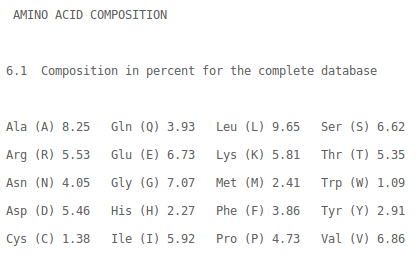

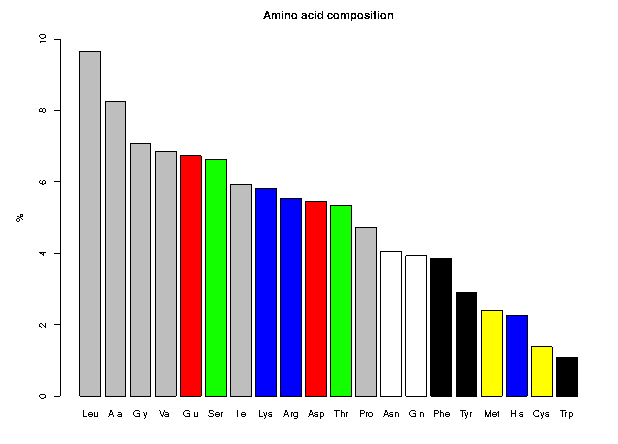

Nous savons que certains acides aminés sont essentiels aux corps humains: 
- (F) Phénylalanine
- (L) Leucine
- (M) Méthionine
- (K) lysine
- (I) Isoleucine
- (V) Valine
- (T) Thréonine
- (W) Tryptophane
- (H) Histidine

De ce fait, l'être humain ne peut pas les produire de lui-même. Ces acides aminés doivent donc lui être apportés par l'alimentation. C'est pourquoi nous constatons des différences de pourcentage entre les différents acides aminés ci-dessus. 


#### formules

Pour construire la matrice profil, nous utilisons ces formules pour calculer chaque valeur de la matrice:

$$Q_{u,a}=\frac{N_{u,a} + \beta.p_{a}}{Nseq + \beta}$$

In [7]:
def q1(self, u, a):
    """
    Calcule les pseudocounts associés à l'acide aminé a
    """
    return (self.number_acids(u, a) + self.beta*(self.pa[a]/100)) \
            / (self.Nseq + self.beta )

Profile.q1 = q1

$$Q_{u,a}=\frac{\alpha.f_{u,a} + \beta.p_{a}}{\alpha + \beta}$$ 

In [8]:
def q2(self, u, a):
    """
    Calcule les pseudocounts associés à l'acide aminé a
    """
    return (self.alpha*self.frequency(u, a) + self.beta*(self.pa[a]/100)) \
            / (self.alpha + self.beta)

Profile.q2 = q2

- $Q_{u,a}$ représente la combinaison des pseudocounts décrits ci-dessous. Les valeurs calculées avec les différents $Q_{u,a}$ sont différentes (ceci sera montré un peu plus tard). Cependant, le consencus final est le même. Nous choisissons donc q2 ci-dessus car il contient un pseudocount supplémentaire $\alpha$ qui ajoute un facteur de cadrage des valeurs observées non négligable.

- $Nseq$ représente le nombre de séquences du MSA
- $F_{u,a}$ représente: 

$$F_{u,a} = \frac{N_{u,a}}{Nseq}$$
C'est la fréquence d'apparition de l'acide aminé a dans la colonne u. Par exemple: 

- TGVEAENLLL
- PRAKAEESLS
- GRKDAERQLL

$F_{1, R} = \frac{2}{3}$ (en comptant les colonnes à partir de 0)
Ici $N_{u,a}$ = 2 car il y a 2 R dans la colonne 1 et $Nseq = 3$ car il y a 3 séquences

In [9]:
def number_acids(self, u, a):
    """
    Calcule le nombre d'acide a dans la colonne u
    """
    Nua = 0 
    for i in range(self.Nseq):
        if self.MSA[i].get_acid(u) == a: # acide aminé a la séquence i, col u
            Nua += 1
    return Nua

Profile.number_acids = number_acids

def frequency(self, u, b):
    """ 
    Calcule la fréquence d'apparition d'un acide aminé b dans la colonne b
    parmi toutes les séquences de l'alignement multiple
    """

    Nub = 0 # nombre d'acide b dans la colonne u
    for i in range(self.Nseq):
        if self.MSA[i].get_acid(u) == b: # acide aminé a la séquence i, col u
            Nub += 1

    return Nub / self.Nseq

Profile.frequency = frequency

$$M_{u,a} = \frac{Q_{u,a}}{p_{a}}$$

- $M_{u,a}$ représente le score pour aligner un résidu et la colonne u.
- $p_{a}$ a deja été décrit plus haut. 

In [10]:
def compute_profile(self, q):
    print("length seq: ", self.Nseq)
    print("beta: ", self.beta)
    print("alpha: ", self.alpha)

    for a in range(self.Nacids):   # lignes
        self.prof.addline()
        for u in range(self.len_seq): # colonnes
            if q == 1:
                Qua = self.q1(u, self.acids[a])
            elif q == 2:
                Qua = self.q2(u, self.acids[a])
            Mua = math.log10(Qua/(self.pa[self.acids[a]]/100))
            self.prof.add_cell(a, Mua)

    self.prof.set_lign([self.pen]*self.len_seq)
    self.prof.panda(self.len_seq)

Profile.compute_profile = compute_profile

#### Pseudocounts

Le problème pouvant survenir lors de la construction du Profil est le manque de certains acides aminés dans des colonnes, provoquant ceci:

$$\log 0 = - \infty$$

qui est inutilisable lorsque l'on voudra aligner ce profil à des séquences protéiques.
C'est pourquoi nous utilisons des pseudocounts (des constantes que l'on ajoute aux valeurs du profil):

- $\alpha = Nseq - 1$ : Le facteur de cadrage pour les données observées
- $\beta = \sqrt {Nseq}$ : Le facteur de cadrage déterminant le nombre de pseudocounts

Nous n'avons pas choisi de prendre $\beta = 1$ car celui-ci corrige de trop s'il y a peu de séquences, et de peu s'il y a trop de séquences.

De ce fait, $Q_{u,a}$ ne sera jamais égal à 0. 

C'est aussi pour cette raison que nous n'utilisons pas cette formule (qui ne contient pas de pseudocounts):

$$M_{u,a} = \sum_{b \in \{AA\}} F_{u,b} S_{a,b} $$

En effet, ette formule utilise une matrice de substitution, qui est obtenue par de nombreuses séquences qui n'ont pas forcément un lien avec les séquences que l'on considère et qui représentent un bromodomaine. Elle induit donc potentiellement de la variabilité que nous voulons éviter.

### Consencus

Après avoir obtenu les Profils, nous calculons le consencus, c'est à dire la séquence qui contient les acides aminés ayant des valeurs maximales dans la matrice profil dans leur position.

Afin d'avoir un résultat qui se rapproche des weblogos construits à partir des alignements de séquences multiples (qui seront décrits plus loin), nous instaurons des gaps. Si, lors du calcul du consencus, nous n'observons que 1 ou 2 acide aminé dans une position, nous insérons un gap car l'information portée par ces quelques acides n'est pas assez pertinente que pour l'afficher et rend la comparaison avec les weblogos difficile. 

De plus, les weblogos introduisent des lettres très compressées lorsqu'il n'y a aucun acide aminé ayant une probabilité énorme d'apparaitre dans une position. Nous pouvons donc considérer ces cas là comme des gap, des espaces.

Ci-dessous, nous avons le code qui crée le consencus, ainsi que la méthode pour l'afficher de manière semblable aux weblogos. La construction de ce consencus se fait comme suit:

- Pour chaque position/colonne dans le MSA, nous prenons l'acide aminé ayant un score maximal dans la matrice PSSM dans la meme position.
- Si ne rencontrons que quelques acides aminés dans une colonne, nous insérons un gap dans la séquence consencus.

In [11]:
def compute_consencus(self):
    """ Renvoie la séquence dont chaque acide aminé possède le score maximal
        dans sa position dans le profil
    """

    for u in range(self.len_seq):
        tmp_max = ["-", -float("inf"), 0]
        for a in range(self.Nseq):
            if self.MSA[a].get_acid(u) != "-":
                Mua = self.prof.get_score(self.acids.index(self.MSA[a].get_acid(u)),u)
                if Mua > tmp_max[1]:
                    tmp_max[0] = self.MSA[a].get_acid(u)
                    tmp_max[1] = Mua
                tmp_max[2] += 1

        if tmp_max[2] <= 10 and self.Nseq > 3:
            tmp_max[0] = "-"
        self.consencus += tmp_max[0]

    self.display_consencus()
    
Profile.compute_consencus = compute_consencus

def display_consencus(self):
    """
    Affiche de manière jolie le consencus 
    """
    print("consencus: ")
    step = 0
    i = 0
    while i < self.len_seq // 40:
        for j in range(step, step+40):
            print(self.consencus[j], end= " ")
        print("\n")
        step += 40
        i += 1
    for j in range(step, self.len_seq):
        print(self.consencus[j], end= " ")
    print("\n")
    
Profile.display_consencus = display_consencus

# EXEMPLE slides
S1 = o.Sequence("1", "TGVEAENLLL")
S2 = o.Sequence("2", "PRAKAEESLS")
S3 = o.Sequence("3", "GRKDAERQLL")
Prof0 = Profile([S1, S2, S3], 4)
Prof0.compute_profile(1)
Prof0.compute_consencus()

Prof01 = Profile([S1,S2,S3], 4)
Prof01.compute_profile(2)
Prof01.compute_consencus()

length seq:  3
beta:  1.7320508075688772
alpha:  2
*      0      1      2      3      4      5      6      7      8      9
R -0.436  0.904 -0.436 -0.436 -0.436 -0.436  0.622 -0.436 -0.436 -0.436
H -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436
K -0.436 -0.436  0.602  0.602 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436
D -0.436 -0.436 -0.436  0.627 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436
E -0.436 -0.436 -0.436  0.545 -0.436  0.991  0.545 -0.436 -0.436 -0.436
S -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436  0.551 -0.436  0.551
T  0.635 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436
N -0.436 -0.436 -0.436 -0.436 -0.436 -0.436  0.747 -0.436 -0.436 -0.436
Q -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436  0.759 -0.436 -0.436
C -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436
G  0.526  0.526 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436
P  0.684 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436 -0.436
A -0.436 -0.4

Voici ci-dessus, l'exemple des slides. La matrice diffère de celle montrée dans les slides car nous avons utilisé des formules différentes (notamment pour le calcul du $Q_{u,a}$). Nous voyons également que les matrices diffèrent selon les formules $Q_{u,a}$ utilisées. La première utilise 
$$Q_{u,a}=\frac{N_{u,a} + \beta.p_{a}}{Nseq + \beta}$$

et la deuxième utilise 
$$Q_{u,a}=\frac{\alpha.f_{u,a} + \beta.p_{a}}{\alpha + \beta}$$ 

Nous constatons que meme en ayant utilisé des pseudocounts différents, nous avons le même consencus. En effet, les valeurs maximales dans chaque position ne changent pas.

De plus, nous obtenons bien un consencus similaire à celui des slides:

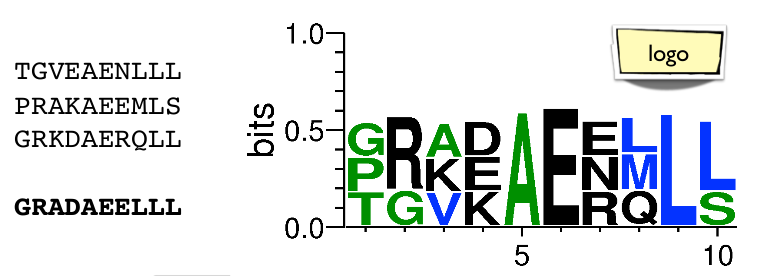

Les acides qui diffèrent dans notre consencus sont ceux qui ont à peu près la même probabilité que les autres acides de la position (nous le voyons sur le weblogo, certaines position contiennent 3 lettres de même taille). Nous pouvons donc choisir n'importe laquelle pour représenter la colonne. Par exemple, 
la première lettre est un P chez nous et un G chez eux. De plus, le consencus des slides est sûrement calculé directement à partir du PSSM: Pour chaque position, ils prennent l'acide aminé dont le score est maximal.

Par contre, les "grosses lettres", donc les acides aminés ayant le plus de chance d'apparaitre dans une colonne sont identiques dans les 2 cas.


### Weblogos

Grâce au site "http://weblogo.threeplusone.com", nous créons nos 2 weblogos à partir des MSA:

- msaresults-MUSCLE (l'alignement multiple de toutes les séquences contenus dans le fichier to-be-aligned.fasta): 



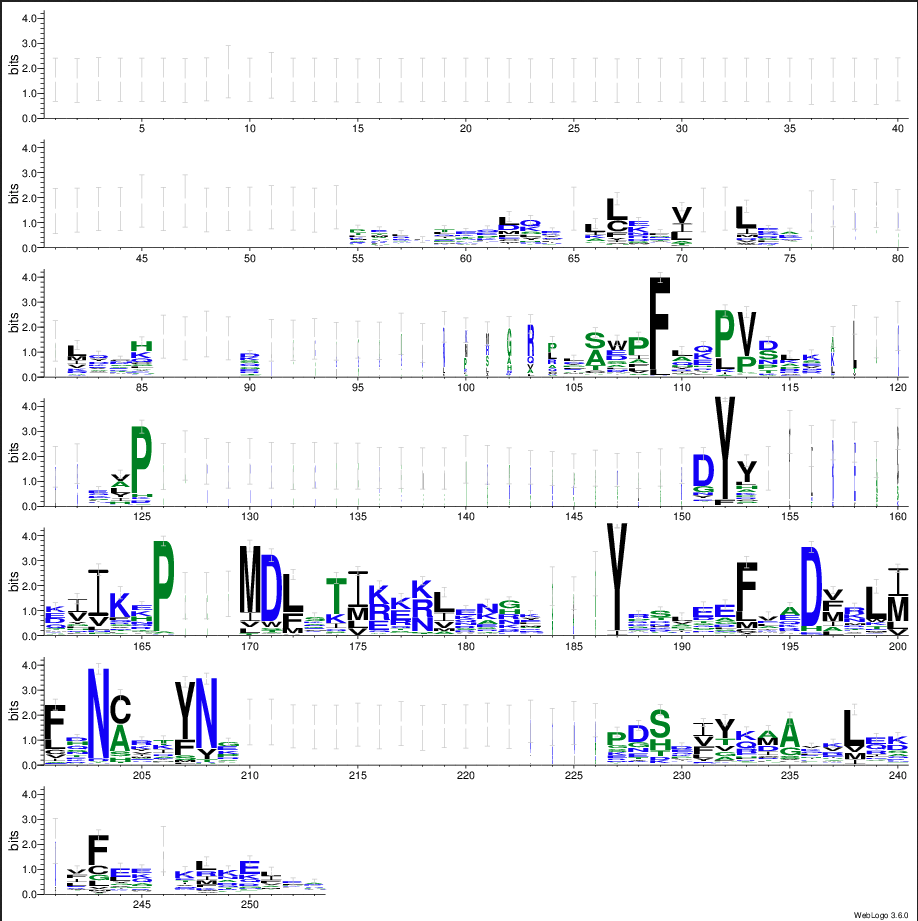



- msaresults-reduced-MUSCLE (l'alignement multiple des séquences ayant au maximum 60 % de similarité entre elles:

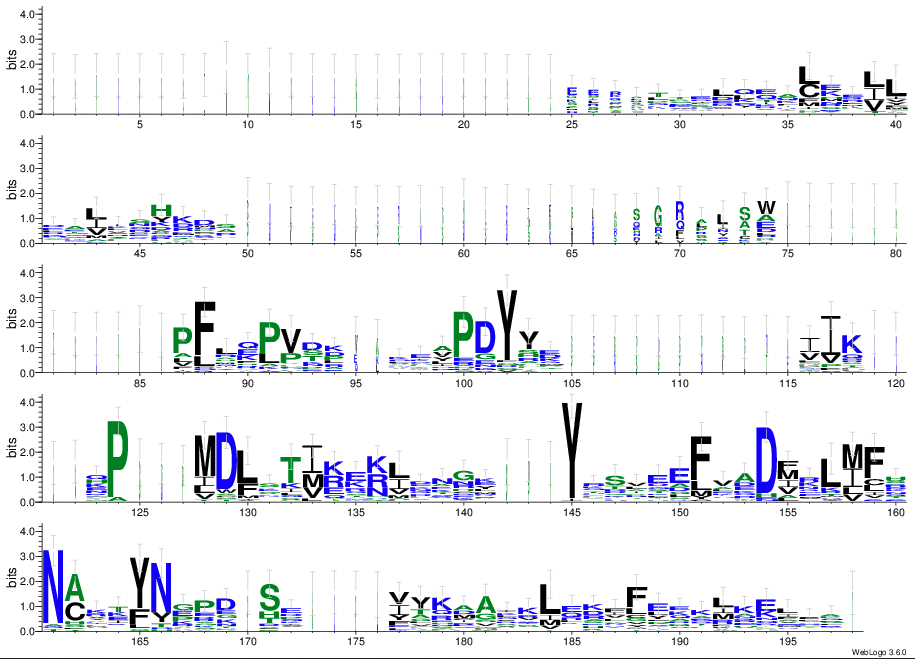


Plus un acide aminé est grand (en hauteur) dans le weblogo , plus il y a de chance d'apparaître dans cette position.
Nous l'utiliserons pour le comparer avec nos consencus créés plus haut.

Nous disposons également du HMM logo, que nous pouvons trouver sur le site http://pfam.xfam.org. Celui-ci représente un Bromo domaine et montre seulement les positions ou il y a un "match", donc pas les insertions et les suppressions d'acides aminés au cours de l'évolution. Il synthétise les acides aminés ayant le plus de probabilité d'apparaître là ou ils se situent. Il ne prend donc pas en considération les autres acides aminés (qui auraient pu être représentés par des gap ici) et enlève donc les gap/petites lettres.

De plus, il est potentiellement différent de nos weblogo car il a été construit sur base d'autres séquences d'acides aminés (Plusieurs familles de protéines du domaine bromo). 

En effet, d'après le site pfam, le HMM logo est construit à l'aide de l'outil Skylign. Celui-ci procède à un modèle markovien caché. 


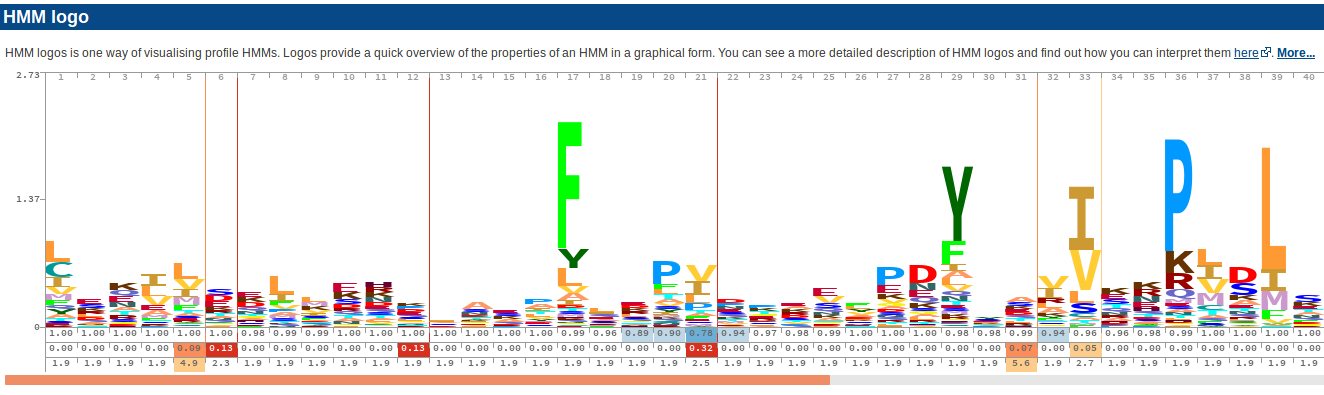

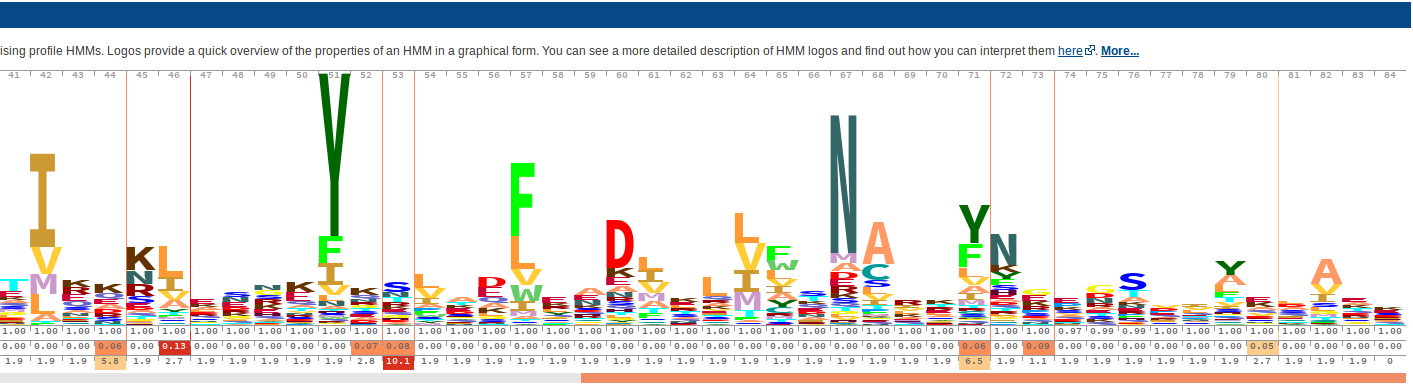

### Alignement au profil

Nous voulons aligner les 2 séquences protéiques donnés aux profils construits afin de mettre en évidence des domaines BRD de ces séquences.

#### local

Nous procédons à un alignement local plutôt que global car un alignement global va regarder si l'ensemble de la séquence correspond au domaine BRD que l'on cherche. Tandis que l'alignement local va essayer de trouver des sous-séquences protéiques hautement similaires au domaine BRD.
    
                                                          Profil (len(MSA))
$$  Sequence  \begin{bmatrix} ... & ... & ... \\... & ... & ... \\ ... & ... & ... \end{bmatrix} $$

Ci-dessous, nous avons une classe représentant un objet "Alignement de séquences local". Celui-ci diffère de l'ancienne version proposée dans la partie 1 du projet. Ces modifications seront détaillés plus loin.

In [12]:
class LocalAlignment(Alignment):
    """
    Classe qui qui va trouver un aligement de séquences d'acides aminées avec
    une méthode locale
    """

    def __init__(self, l, I, E, mat_file, seq1, seq2, p, prof=None):
        Alignment.__init__(self, I, E, mat_file, seq1, seq2, p, prof)
        self.l = l

        self.S.init_S_local()  # On initialise la matrice de scoring
        self.S.setup_seq("-"+self.seq1.get_acids(), "-"+self.seq2.get_acids())

        self.zeros = []
        self.found = False
    
    def sol_found(self, i,j):
        """ Détermine si on a fini un alignement local """

        return (i == 0 or j == 0 or self.S.get_score(i,j) == 0)

    def bottom_up(self, i,j):
        """ Remonte la matrice de scoring a partir du max de la matrice
            de scoring jusqu'à un élément de la 1ere ligne ou 1ere colonne
            ou un élément 0
        """
        while not self.sol_found(i,j):
            prev_i = i
            prev_j = j
            pos = 2
            if self.is_previous("v", i, j) or \
                self.prof != None and self.is_previous("vp", i, j): # haut
                i-=1
                pos = 0
            elif self.is_previous("w", i, j) or \
                self.prof != None and self.is_previous("wp", i, j): # gauche
                j-=1
                pos = 1
            elif self.is_previous("s", i, j) or \
                self.is_previous("sp", i, j):  # diagonale
                i-=1
                j-=1
            if self.S.get_score(i,j) != 0:
                self.add_sol(prev_i,prev_j,pos, self.prof != None)
                self.zeros.append((prev_i,prev_j))

        self.all_solutions.append(self.current_sol)
        self.add_sol(prev_i, prev_j, 2, self.prof != None)
        self.zeros.append((prev_i, prev_j))

    def Smith_Waterman(self):
        self.compute_scoring(1,1)
        
        if self.prof != None:
            self.all_solutions.append(self.seq2)

        for i in range(self.l):
            current_max = self.S.get_max()
            self.bottom_up(current_max[0], current_max[1])
            if i == self.l-1: # Si on a trouvé l solutions
                break
            # une fois le backtrack fini, on met a 0 l'alignement 
            sols = len(self.current_sol)
            self.S.set_zero(self.zeros[len(self.zeros)-sols:])
            if self.prof == None:
                self.V.set_zero(self.zeros[len(self.zeros)-sols:])
                self.W.set_zero(self.zeros[len(self.zeros)-sols:])

            self.current_sol = []
            if self.p == 2:
                print("mise a 0: ")
                self.S.panda()

                print("recalcul de la matrice: ")
            self.compute_scoring(self.zeros[-1][0], self.zeros[-1][1])

        R = Result(self.all_solutions, self.p)
        if self.prof == None:
            return R.bind()
        else:
            return R.display_local_prof()

#### Changements

Après avoir initialisé la matrice S, comme suit:

$$
S = \begin{bmatrix} 0 & 0 & 0 & ... \\ 0 \\ 0\\ ... \end{bmatrix} 
$$

nous procédons au calcul de la matrice de scoring. Dans la partie précédente, nous la calculions de cette manière: 

$$V(i,j) = max\left\{ \begin{array}{ll} S(i - 1, j) - I \\ V(i - 1, j) - E
    \end{array} \right.$$

$$W(i,j) = max\left\{ \begin{array}{ll} S(i, j - 1) - I \\ W(i, j - 1) - E
    \end{array} \right.$$

$$S(i,j) = max\left\{ \begin{array}{ll} S(i - 1, j - 1) + MatSubstitution(i, j) \\
        V(i, j) \\ W(i, j) \\ 0 \end{array} \right.$$
        
Cette fois-ci, nous n'utilisons plus de matrices de substitution. Nous utilisons le PSSM calculé au préalable. Les calculs sont désormais ceux-ci:

$$S(i,j) = max\left\{ \begin{array}{ll} S(i - 1, j - 1) + PSSM(seq(i), j) \\
        S(i-1,j) + PSSM("-", j) \\ S(i, j - 1) + PSSM("-", j - 1) \\ 0 \end{array} \right.$$
        
        
ou seq(i) représente l'acide aminé à la ligne i et j représente la colonne/position considérée.

Ceci est réalisé par les 2 méthodes ci-dessous (l'une va calculer les scores S et l'autre va construire la matrice sur base des différentes valeurs de S)

In [13]:
def get_s_local(self, i, j, v_ij, w_ij):
    """ détermine la valeur de S en fonction de V et W et de t"""

    if self.prof == None: # Si on n'aligne pas à un profil
        letters_ij = self.S.get_letters(i,j) # 'AB' par exemple
        t_ij = self.t.get_acid_score(letters_ij[0], letters_ij[1])
        return max( self.S.get_score(i-1,j-1) + t_ij, v_ij, w_ij, 0 )

    else: 

        pssm_ij = self.prof.get_cell(\
            self.prof.acid_pos(self.seq2.get_acid(i-1)),j-1)
        return max(self.S.get_score(i-1,j-1) + pssm_ij, v_ij, w_ij, 0)
    
LocalAlignment.get_s_local = get_s_local

def compute_scoring(self, start_i, start_j):
    """ 
    Calcule la matrice de scoring pour l'alignement local
    """

    # ==================== CREATION SCORING ===========================

    for i in range(start_i, self.m):
        for j in range(start_j, self.n):
            if (i,j) not in self.zeros:
                if self.p == None:
                    v_ij = self.get_v(i, j)     # V(i,j)
                    self.V.set_score(i,j, v_ij)
                    w_ij = self.get_w(i, j)     # W(i,j)
                    self.W.set_score(i,j, w_ij)
                elif self.prof != None:
                    v_ij = self.S.get_score(i-1,j) - self.I
                    w_ij = self.S.get_score(i,j-1) - self.I
                s_ij = self.get_s_local(i, j, v_ij, w_ij)
                self.S.set_score(i, j, s_ij)

    if self.p == 2:
        print("la matrice de Scoring: ")
        self.S.panda()
        
LocalAlignment.compute_scoring = compute_scoring

#### Remarque

- Lors du calcul de la matrice de scoring, nous devons utiliser les pénalités de gap contenus dans la dernière ligne de la matrice Profil. Normalement, celles-ci varient en fonction des colonnes. En effet, il se peut qu'une partie des acides aminés représentent des hélices ou des brins dans la structure tridimensionnelle. Il faudrait tenir compte de ces structures en mettant des pénalités différentes. Par exemple, mettre une grande pénalité pour préserver les hélices de quelconques multations génétiques au cours de l'évolution. Cependant, nous avons choisi de ne pas faire de distinction entre les différentes positions. La pénalité linéaire est fixe et identique sur toute la ligne. Dès lors, dans le calcul de la matrice de scoring, nous utilisons I = E = pénalité linéaire plutôt que PSSM("-", j) car cela revient au même et nous obtenons les mêmes résultats, comme nous le verrons dans la section Résultats & Discussion.


#### Calcul des sous-séquences

Après avoir construit la matrice de scoring avec la nouvelle formule, nous procédons à la remontée de cette matrice afin de déduire la sous-séquence actuelle obtenue. Dans la partie précédente, chaque élément était déterminé par ces éléments:
$$  \begin{bmatrix} S(i-1,j-1)+t(i,j) & V(i,j) \\ W(i,j) & S(i,j) \end{bmatrix} $$

Maintenant, chaque case est déterminé par ces éléments:
$$  \begin{bmatrix} S(i-1,j-1)+PSSM(seq(i),j) & S(i - 1, j) + PSSM("-", j) \\ S(i, j - 1) + PSSM("-", j - 1) & S(i,j) \end{bmatrix} $$

La méthode is_previous ci-dessous va regarder quel élément a déterminé la valeur à l'élément S(i,j).

In [14]:
def is_previous(self, mat, i, j):
    """ Regarde si l'élement ij résulte de l'élément en diagonale,
        en haut ou a gauche 
    """

    res = False
    if mat == "v" and self.V.get_score(i,j) == self.S.get_score(i,j):
        res = True 

    elif mat == "w" and self.W.get_score(i,j) == self.S.get_score(i,j):
        res = True 

    elif mat == "s":
        letters_ij = self.S.get_letters(i,j) # 'AB' par exemple
        t_ij = self.t.get_acid_score(letters_ij[0], letters_ij[1])  # t(i,j)

        if self.S.get_score(i-1, j-1) + t_ij == self.S.get_score(i,j):
            res = True 
            
    elif mat == "vp" and self.S.get_score(i-1,j)-self.I == self.S.get_score(i,j):
        res = True 
    elif mat == "wp" and self.S.get_score(i,j-1)-self.I == self.S.get_score(i,j):
        res = True

    elif mat == "sp": # Si on a aligné à un profil
        pssm_ij = self.prof.get_cell(\
            self.prof.acid_pos(self.seq2.get_acid(i-1)),j-1)
        if self.S.get_score(i-1, j-1) + pssm_ij == self.S.get_score(i,j):
            res = True 

    return res 

Alignment.is_previous = is_previous

A chaque étape de la remontée, nous ajoutons un par un les éléments considérés. Ici, nous gardons les positions dans la séquence protéique. Cela permettra de déterminer le sous-intervalle de la séquence complète que nous avons trouvé.

In [15]:
def add_sol(self, i, j, pos, p):
    """ Ajoute une solution à la liste des solutions
        De la forme: ('AB', score)
    """

    if p: # Si on aligne au profil
        self.current_sol.append(i)
    else:
        letters_ij = self.S.get_letters(i,j) 
        if pos == 0:
            letters_ij = letters_ij[0]+"-" # A- par exemple => Si gap vient de V
        elif pos == 1:
            letters_ij = "-"+letters_ij[1] # -A par exemple => Si gap vient de W
        else:
            self.current_sol.append((letters_ij, \
                            self.t.get_acid_score(letters_ij[0], letters_ij[1])))
        
Alignment.add_sol = add_sol

Ci-dessous, nous avons la classe représentant un Résultat d'un alignement de séquences (local ou global). Celui n'a pas changé hormis pour l'affichage du résultat d'un alignement local avec un Profil. La méthode display_local_prof va afficher les sous-intervalles trouvés suite à l'alignement. 

In [16]:
class Result:
    """ Classe représentant un objet Résultat dans laquelle on va créer le
        résultat de l'alignement global ou local
    """

    def __init__(self, all_sol, p):
        self.all_sol = all_sol 
        self.p = p 
        self.scores = [] # score de similarité de tous les alignements

    def bind(self):
        """ Crée les liaisons entre 2 séquences + leurs scores de similarité """

        for sol in self.all_sol:
            seq1, seq2, links = "", "", ""
            for i in range(len(sol)-1, -1, -1):
                seq1 += sol[i][0][1]  # 2eme lettre
                seq2 += sol[i][0][0]  # 1ere lettre

                if sol[i][0][1] == "-" or sol[i][0][0] == "-": # SI gap
                    links += " "   # Pas de correspondance
                else:
                    if sol[i][0][1] == sol[i][0][0]:
                        links += ":"       # Identiques
                    elif sol[i][1] >= 0:   # Si le score est positif => similaires
                        links += "."
                    else:
                        links += " "

            # pourcentage de similarité
            similarity = ((links.count(".")+links.count(":"))/len(links)) * 100
            identity = (links.count(":")/len(links)) * 100 # pourcentage d'identité
            self.scores.append(similarity)
            
            if self.p == 1 or self.p == 2: # Si on veut afficher les résultats
                self.print_result(seq1, seq2, links, similarity, identity)

        return self.scores

    def print_result(self, seq1, seq2, links, similarity, identity):
        """ Imprime de manière jolie les 2 séquences alignées 
            seq est de la forme: [('AB', scoreAB), .. ]
        """

        print("\n>>> Alignement: ")

        i, j = 0, 0
        while i < (len(seq1) // 60):
            print(seq1[j:j+60]+"\n"+links[j:j+60]+"\n"+seq2[j:j+60]+"\n\n")
            i += 1
            j += 60
        end = len(seq1) - len(seq2)%60
        print(seq1[end:]+"\n"+links[end:]+"\n"+seq2[end:]+"\n\n")

        print("==> similarité: {0} %".format(similarity))
        print("==> Identité: {0} %".format(identity))

    def display_local_prof(self):
        """
        Imprime les sous-chaînes issues de l'alignement local entre une séquence
        de prot et un Profil
        """
        for sol in range(1, len(self.all_sol)):
            tmp_res = ""
            for i in range(self.all_sol[sol][-1]-1, self.all_sol[sol][0]-1):
                tmp_res += self.all_sol[0].get_acid(i) 
            print("Sous séquence obtenue: {0}, taille: {1} ".format(tmp_res, len(tmp_res)))
            print("=> intervalle: [{0} -> {1}]".format(
                self.all_sol[sol][-1], self.all_sol[sol][0]-1))

## Résultats & Discussion

Dans cette section, nous allons procéder aux tests qui engendreront des résultats que nous discuterons également dans cette section.

### PSSM & Weblogo

Nous allons maintenant analyser nos PSSM et nos weblogos.

Tout d'abord, nous récupérons les séquences alignées de manière multiple (les séquences ayant au maximum 60% de similarité entre elles et les autres):

In [17]:
MSA1 = o.ParserSequence("msaresults-MUSCLE.fasta") 
MSA1.parse() # alignements multiples de séquences 

MSA2 = o.ParserSequence("msaresults-reduced-MUSCLE.fasta") 
MSA2.parse() # alignements multiples de séquences réduits

#### PSSM 1 - MSA1

In [18]:
Prof = Profile(MSA1.get_all_seq(), 4)
Prof.compute_profile(2)
Prof.compute_consencus()

length seq:  223
beta:  14.933184523068078
alpha:  222
*    0      1      2      3      4      5      6      7      8      9    \
R -0.857 -1.200 -1.200 -0.857 -0.857 -0.857 -1.200 -1.200 -1.200 -1.200   
H -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200   
K -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200   
D -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200   
E -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200   
S -1.200 -0.898 -1.200 -1.200 -1.200 -1.200 -0.898 -1.200 -1.200 -1.200   
T -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -0.849   
N -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200   
Q -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200   
C -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200   
G -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200 -1.200   
P -1.200 -1.200 -0.819 -1.200 -1.200 -1.200 -

Ci-dessus, nous avons le résultat du consencus après avoir créé le Profil avec le premier MSA, donc l'alignement multiple de toutes les séquences contenues dans le fichier to-be-aligned.fasta.
Nous avons le weblogo correspondant ci-dessous.
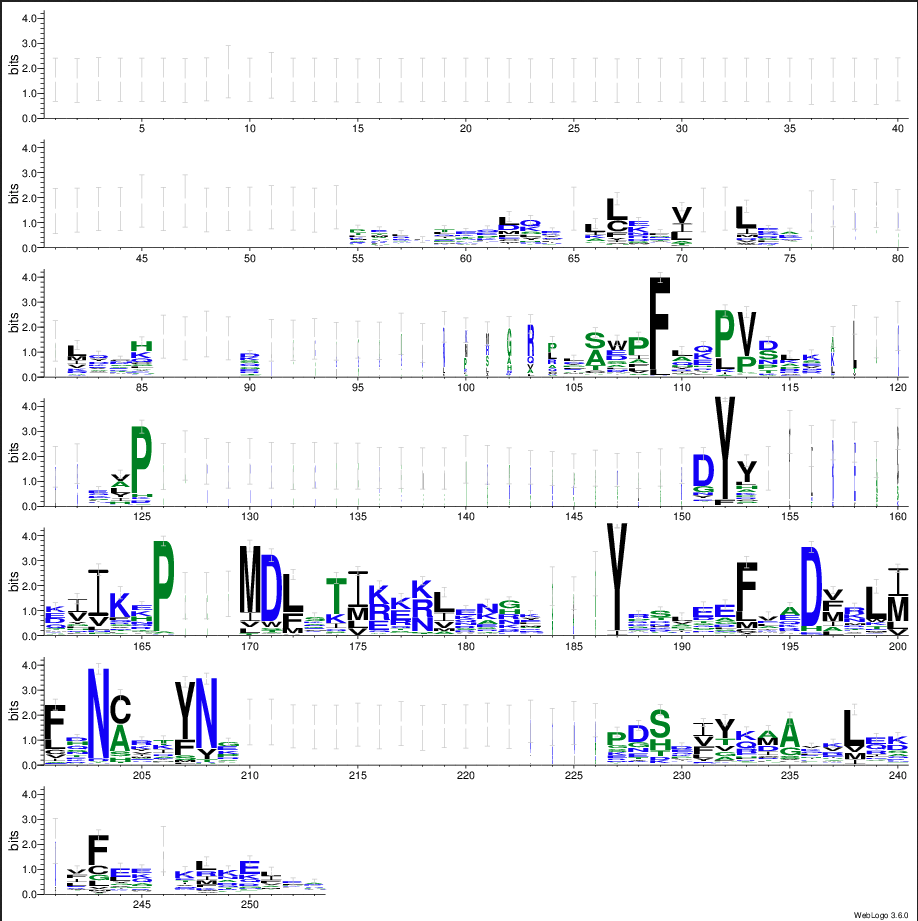

Nous constatons que le consencus et le weblogo sont similaires à +/- 90%. En effet, la plupart des acides aminés ayant le plus de probabilité d'apparaître dans une position dans notre consencus (les grosses lettres) sont également présentes dans le weblogo dans les memes positions.

Certaines positions diffèrent. Par exemple, à la position 229 du weblogo, nous avons un S très probable, et dans notre consencus, nous avons un H qui s'avère être un peu moins probable que l'acide S.

Ci-dessous, nous avons le HMM logo provenant du site PFAM.

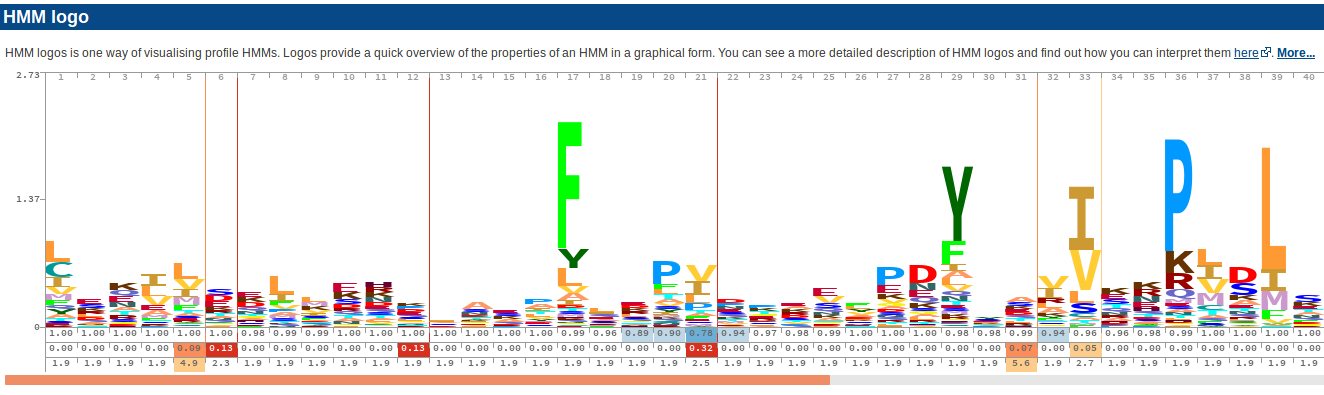

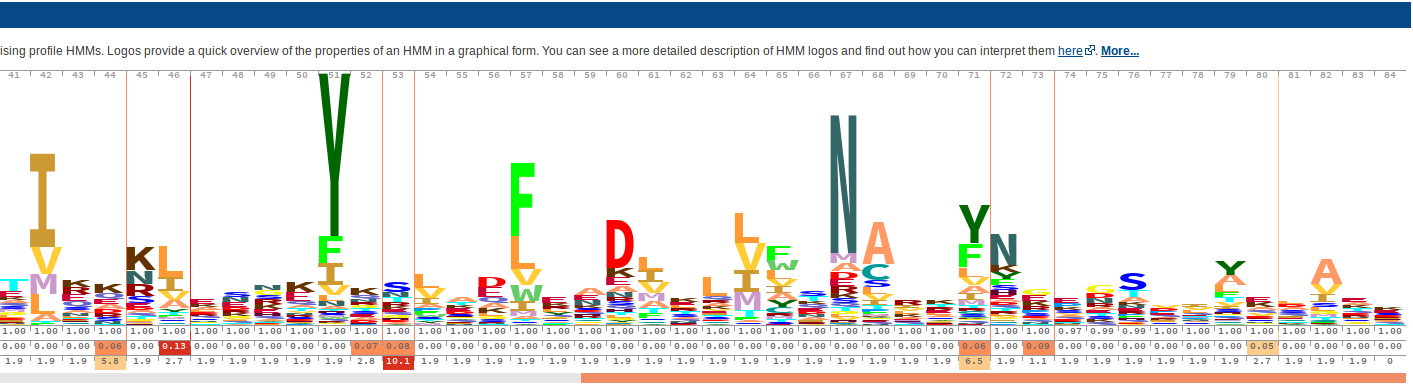

Les acides ayant le plus de probabilité d'apparaître dans leur position sont:

- 15: F
- 20: P
- 21: V
- 29: Y
- 33: I
- 36: P
- 39: L
- 42: I
- 51: Y
- 57: F
- 60: D
- 64: L
- 67: N
- 68: 1
- 71: Y
- 72: N
- 79: X
- 82: A


Nous constatons que ces acides aminés se trouvent également dans nos weblogos et notre consencus. Si nous regardons les lettres une par une, nous les voyons aussi apparaître dans le même ordre (grosses lettres) dans notre consencus.


#### PSSM 2 - MSA 2 (reduced)

In [19]:
Prof1 = Profile(MSA2.get_all_seq(), 4)
Prof1.compute_profile(2)
Prof1.compute_consencus()

length seq:  34
beta:  5.830951894845301
alpha:  33
*    0      1      2      3      4      5      6      7      8      9    \
R -0.220 -0.823 -0.823 -0.220 -0.220 -0.220 -0.823 -0.823 -0.823 -0.823   
H -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823   
K -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823   
D -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823   
E -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823   
S -0.823 -0.278 -0.823 -0.823 -0.823 -0.823 -0.278 -0.823 -0.823 -0.823   
T -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.209   
N -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823   
Q -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823   
C -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823   
G -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823 -0.823   
P -0.823 -0.823 -0.168 -0.823 -0.823 -0.823 -0.8

Ci-dessus, nous avons le résultat du consencus après avoir créé le Profil avec le deuxième MSA, donc l'alignement multiple de toutes les séquences ayant maximum 60% de similarités entre eux (to-be-aligned-reduced.fasta)
Nous avons le weblogo correspondant ci-dessous.

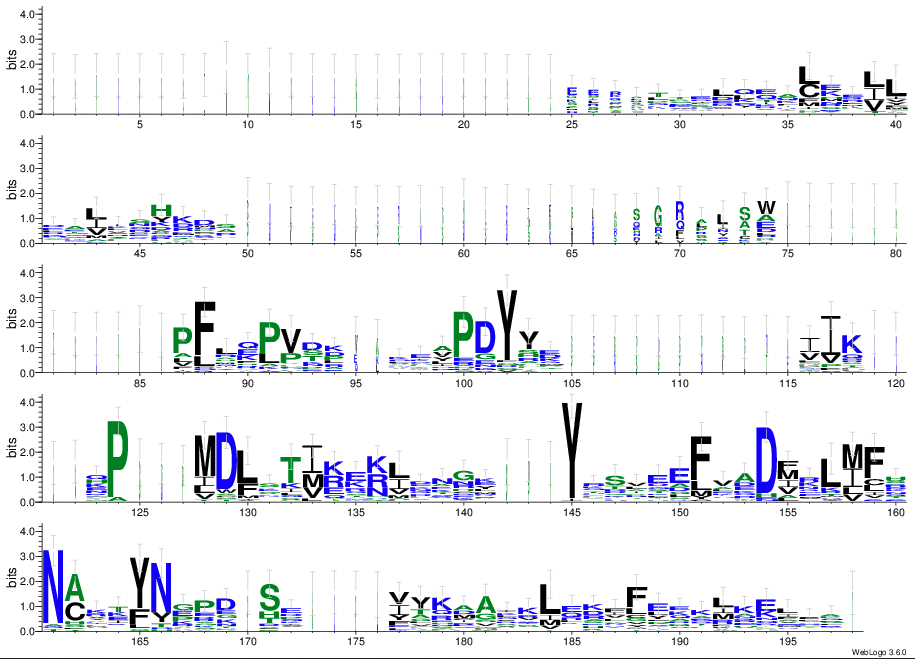

Nous pouvons voir que le weblogo ressemble fortement à notre consencus généré. En effet, les acides aminés les plus probables sont identiques. Par exemple:
- position 124: P
- position 129: D
- position 145: Y
- position 154: D
- position 161: N
- etc..

Certaines positions diffèrent un petit peu. Par exemple, à la postion 162, le weblogo contient un A plus probable et un C juste en dessous. Notre consencus prend le C.

Ci-dessous, nous avons le HMM logo provenant du site PFAM. 

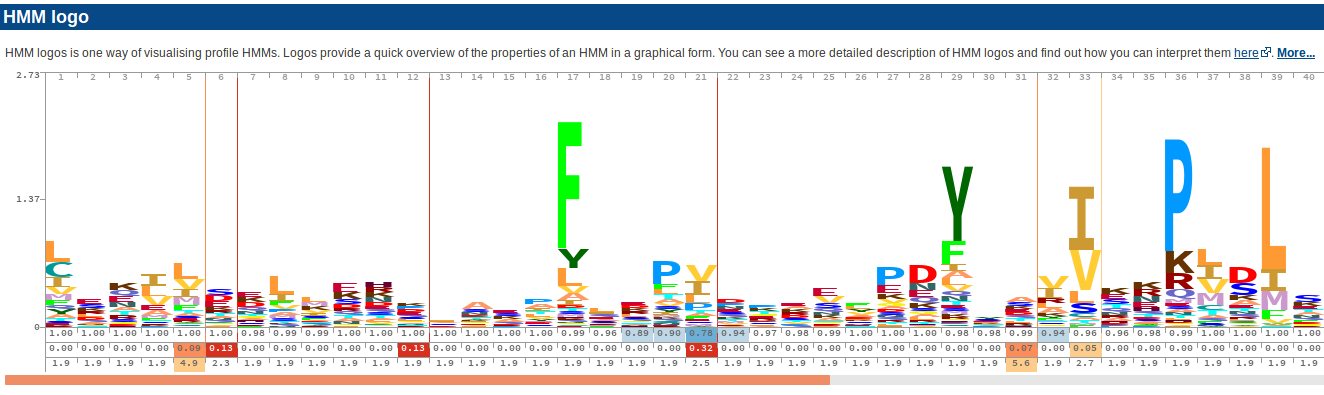

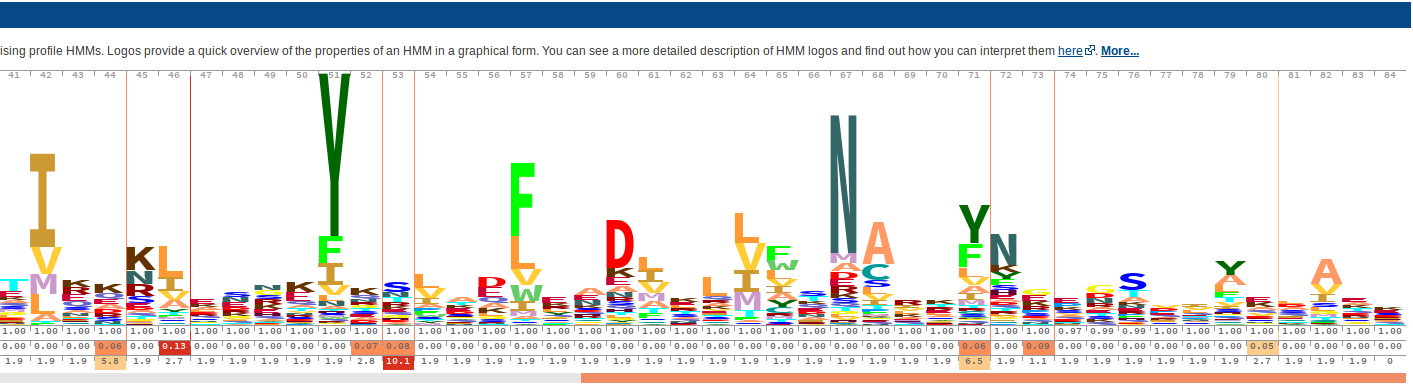

Comme nous l'avons deja mentionné plus haut, les acides ayant le plus de probabilité d'apparaître dans leur position sont:

- 15: F
- 20: P
- 21: V
- 29: Y
- 33: I
- 36: P
- 39: L
- 42: I
- 51: Y
- 57: F
- 60: D
- 64: L
- 67: N
- 68: A
- 71: Y
- 72: N
- 79: X
- 82: A


Nous voyons que une fois de plus, notre consencus et les weblogos coincident avec le HMM logos pour les positions ci-dessus.

#### Bilan

Les 2 weblogos ressemblent fortement à nos consencus calculés et au HMM logo malgré le fait que ceux-ci ont été calculés différemment (comme nous l'avons discuté dans la section Méthode plus haut). 

### Local

Nous analysons à présent les alignements locaux des séquences protéiques avec les Profils calculés ci-dessus.
Tout d'abord, nous récupérons les 2 protéines que nous allons aligner: 

In [20]:
P = o.ParserSequence("protein-sequences.fasta") # protéines à aligner avec profil
P.parse()

#### gap

Nous partons du principe que lorsque nous alignons une séquence à un profil, nous n'allons pas introduire de gap étant donné que les gaps signifient une suppression d'un acide aminé au cours de l'évolution. Dans notre cas, nous voulons seulement les sous-séquences correspondant au bromodomaine et par conséquent les sous-intervalles qui leur correspondent. 

#### Séquence 1 - Profil 1 - Pénalité 4

Nous allons aligner la première séquence avec le Profil calculé à partir de msaresults-MUSCLE.fasta avec une pénalité linéaire de 4, donc ce n'est pas très pénalisant.

- Proteine: Transcription initiation factor TFIID subunit 1
- Gène: TAF1

In [21]:
print("Alignement Séquence 1 avec profil")
Lp0 = LocalAlignment(2, 4, 4, "blosum62.txt", o.Sequence("", "-"*(MSA1.get_seq(0).length())),
                        P.get_seq(0), 1, Prof)
Lp0.Smith_Waterman()

Alignement Séquence 1 avec profil
Sous séquence obtenue: YQSRESFLDDVNLILANSVKYN, taille: 22 
=> intervalle: [1562 -> 1583]
Sous séquence obtenue: YPSREEFREHLELIVKNSATYN, taille: 22 
=> intervalle: [1439 -> 1460]


Nous obtenons 2 sous-séquences.

D'après les données de UNIPROT, la séquence contient 2 bromodomaines:

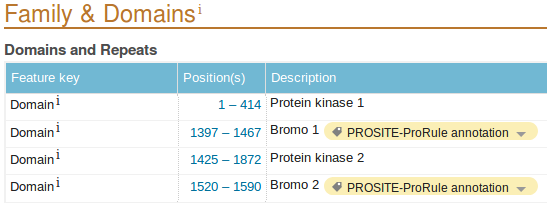

Nous utiliserons ceci comme référence afin de comparer nos résultats pour plus de facilité:

- Bromo1: [1397 – 1467]
- Bromo2: [1520 – 1590]

Dans notre cas, nous avons (uniprot a gauche et nous a droite):

- Bromo1: [1397 – 1467] ------|------ [1439 -> 1460]
- Bromo2: [1520 – 1590] ------|------ [1562 -> 1583]

Nous avons donc bien obtenu les 2 bromodomaines mais les positions de départ et d'arrivée font que nous obtenons un sous-intervalle donc pas la sous-séquence complète (comme nous pouvons le voir ci-dessous).

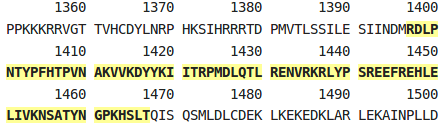

Nous: 
- YQSRESFLDDVNLILANSVKYN
- YPSREEFREHLELIVKNSATYN

#### Séquence 1 - Profil 1 - Pénalité 0.5

Nous testons ensuite avec une pénalité linéaire de 0.5, donc très peu pénalisante:

In [22]:
print("Alignement Séquence 1 avec profil")
Lp0 = LocalAlignment(2, 0.5, 0.5, "blosum62.txt", o.Sequence("", "-"*(MSA1.get_seq(0).length())),
                        P.get_seq(0), 1, Prof)
Lp0.Smith_Waterman()

Alignement Séquence 1 avec profil
Sous séquence obtenue: DYYKVIVNPMDLETIRKNISKHKYQSRESFLDDVNLILANSVKYN, taille: 45 
=> intervalle: [1539 -> 1583]
Sous séquence obtenue: DYYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVKNSATYN, taille: 45 
=> intervalle: [1416 -> 1460]


Cette fois-ci, nous avons des intervalles plus proches que la dernière fois des données de UNIPROT:

- Bromo1: [1397 – 1467] ------|------ [1416 -> 1460]
- Bromo2: [1520 – 1590] ------|------ [1539 -> 1583]

Nous avons donc une corrélation entre pénalité de gap et grandeur de l'intervalle !

#### Séquence 1 - Profil 2 - Pénalité 4

Nous testons maintenant d'aligner le Profil obtenu avec msaresults-reduced-MUSCLE.fasta avec la 1ère séquence:

In [23]:
print("Alignement Séquence 1 avec profil de reduced")
Lp1 = LocalAlignment(2, 4, 4, "blosum62.txt", o.Sequence("", "-"*(MSA2.get_seq(0).length())),
                        P.get_seq(0), 1, Prof1)
Lp1.Smith_Waterman()

Alignement Séquence 1 avec profil de reduced
Sous séquence obtenue: YQSRESFLDDVNLILANSVKYNGP, taille: 24 
=> intervalle: [1562 -> 1585]
Sous séquence obtenue: YPSREEFREHLELIVKNSATYNGPKH, taille: 26 
=> intervalle: [1439 -> 1464]


En comparant avec UNIPROT, nous avons:
    
- Bromo1: [1397 – 1467] ------|------ [1439 -> 1464]
- Bromo2: [1520 – 1590] ------|------ [1562 -> 1585]

Ce qui est très proche également.

Nous pourrons comparer ces valeurs avec celles obtenues dans les 2 PSSM:

- Bromo1: [1439 -> 1460] ------|------ [1439 -> 1464]
- Bromo2: [1562 -> 1583] ------|------ [1562 -> 1585]

A gauche, nous avons les intervalles obtenus avec le profil du MSA avec toutes les séquences de to-be-aligned.fasta et à droite, nous avons les intervalles obtenus avec le profil du MSA réduit, donc avec les séquences ayant au maximum 60% de similarité entre elles. Nous voyons que les résultats sont quasiment identiques. Ceci est expliqué par le fait que lorsque nous avons enlevé les séquences dont le score de similarité était > 60% avec tous les autres, nous avons gardé tout de même les séquences dans notre ensemble qui est similaire à ces séquences non sélectionnées. De ce fait, l'alignement produit le même résultat.

#### Séquence 2 - Profil 1 - Pénalité 4

Nous allons maintenant analyser l'alignement local avec notre 2ème séquence:

- Proteine: Protein polybromo-1
- Gène: PBRM1

Nous l'alignons avec le profil obtenu avec msaresults-MUSCLE.fasta

In [24]:
print("Alignement Séquence 2 avec profil")
Lp2 = LocalAlignment(6, 4, 4, "blosum62.txt", o.Sequence("", "-"*(MSA1.get_seq(0).length())),
                        P.get_seq(1), 1, Prof)
Lp2.Smith_Waterman()

Alignement Séquence 2 avec profil
Sous séquence obtenue: YQDIDSMVEDFVMMFNNACTYN, taille: 22 
=> intervalle: [718 -> 739]
Sous séquence obtenue: YAGEEGMIEDMKLMFRNARHYN, taille: 22 
=> intervalle: [580 -> 601]
Sous séquence obtenue: YETLDHLECDLNLMFENAKRY, taille: 21 
=> intervalle: [442 -> 462]
Sous séquence obtenue: YKSIHAMAKDIDLLAKNAKTYN, taille: 22 
=> intervalle: [242 -> 263]
Sous séquence obtenue: YDDVNLLTADFQLLFNNAKSYY, taille: 22 
=> intervalle: [106 -> 127]
Sous séquence obtenue: YRRLDLFQEHMFEVLERARRMN, taille: 22 
=> intervalle: [834 -> 855]


Nous obtenons 6 sous-séquences.

D'après les données de UNIPROT, nous devons avoir:

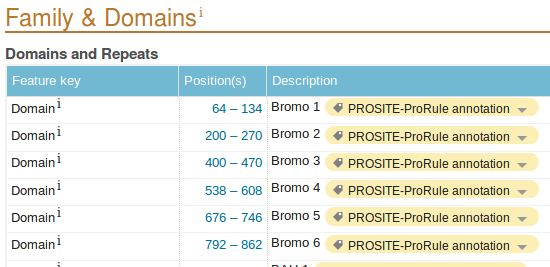

Nous utiliserons ceci afin de comparer nos résultats avec plus de simplicité:

- Bromo1: [64 – 134]
- Bromo2: [200 – 270]
- Bromo3: [400 – 470]
- Bromo4: [538 – 608]
- Bromo5: [676 – 746]
- Bromo6: [792 – 862]

Dans notre cas, nous avons:

- Bromo1: [64 – 134] ------|------ [106 -> 127]
- Bromo2: [200 – 270] ------|------ [242 -> 263]
- Bromo3: [400 – 470] ------|------ [442 -> 462]
- Bromo4: [538 – 608] ------|------ [580 -> 601]
- Bromo5: [676 – 746] ------|------ [718 -> 739]
- Bromo6: [792 – 862] ------|------ [834 -> 855]

Nous constatons que, comme pour la 1ère séquence, nous obtenons des sous-intervalles de ceux que nous sommes sensé avoir. Les positions de fin sont plus proches de ceux de Uniprot que les positions de début qui sont eux un peu plus éloignés. Ceci peut etre corrigé à l'aide de la pénalité, comme nous l'avons également vu.

Voici la comparaison de nos sous-séquences avec les leurs:

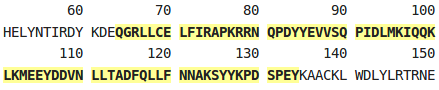

> YDDVNLLTADFQLLFNNAKSYY

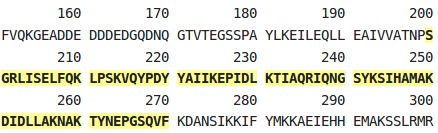

> YKSIHAMAKDIDLLAKNAKTYN

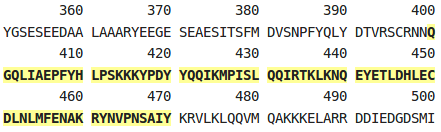

> YETLDHLECDLNLMFENAKRY

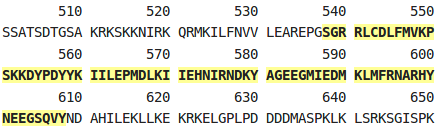

> YAGEEGMIEDMKLMFRNARHYN

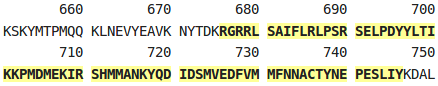

> YQDIDSMVEDFVMMFNNACTYN

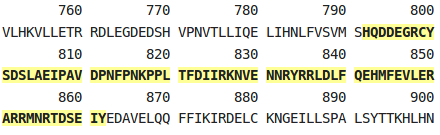

> YRRLDLFQEHMFEVLERARRMN


#### Séquence 2 - Profil 1 - Pénalité 1

Nous allons voir maintenant le même alignement mais avec une pénalité moins stricte pour appliquer la corrélation

In [25]:
print("Alignement Séquence 2 avec profil")
Lp2 = LocalAlignment(6, 0.3, 0.3, "blosum62.txt", o.Sequence("", "-"*(MSA1.get_seq(0).length())),
                        P.get_seq(1), 1, Prof)
Lp2.Smith_Waterman()

Alignement Séquence 2 avec profil
Sous séquence obtenue: DYYKIILEPMDLKIIEHNIRNDKYAGEEGMIEDMKLMFRNARHYNEEGSQVYNDAHILEKLLKEKRKELG, taille: 70 
=> intervalle: [557 -> 626]
Sous séquence obtenue: DYYLTIKKPMDMEKIRSHMMANKYQDIDSMVEDFVMMFNNACTYNEPESLIYKDALVLHKVLLETRRDL, taille: 69 
=> intervalle: [695 -> 763]
Sous séquence obtenue: DYYAIIKEPIDLKTIAQRIQNGSYKSIHAMAKDIDLLAKNAKTYNEPGSQVFKDANSIKKIFYMKKAEIE, taille: 70 
=> intervalle: [219 -> 288]
Sous séquence obtenue: DYYQQIKMPISLQQIRTKLKNQEYETLDHLECDLNLMFENAKRYNVPNSAIYKRVLKLQQVMQAKKKELAR, taille: 71 
=> intervalle: [419 -> 489]
Sous séquence obtenue: DYYEVVSQPIDLMKIQQKLKMEEYDDVNLLTADFQLLFNNAKSYYKPDSPEYKAACKLWDLYLRTRNEFV, taille: 70 
=> intervalle: [83 -> 152]
Sous séquence obtenue: KPPLTFDIIRKNVENNRYRRLDLFQEHMFEVLERARRMNRTDSEIYEDAVELQQFFIKIRDELC, taille: 64 
=> intervalle: [817 -> 880]


En comparant avec Uniprot de nouveau, nous avons:

- Bromo1: [64 – 134] ------|------ [83 -> 152]
- Bromo2: [200 – 270] ------|------ [219 -> 288]
- Bromo3: [400 – 470] ------|------ [419 -> 489]
- Bromo4: [538 – 608] ------|------ [557 -> 626]
- Bromo5: [676 – 746] ------|------ [695 -> 763]
- Bromo6: [792 – 862] ------|------ [817 -> 880]

Par rapport au dernier résultat, nous voyons bien que les positions de départ se sont rapprochées de celles de UNIPROT. La corrélation est donc correcte également dans le cas.
Par contre, nous constatons que les positions d'arrivées ont dépassé celles de UNIPROT. Ceci peut etre du à la pénalité.


Voici les résultats obtenus maintenant comparées a ceux juste avant:

- Bromo1: [106 -> 127] ------|------ [83 -> 152]
- Bromo2: [242 -> 263] ------|------ [219 -> 288]
- Bromo3: [442 -> 462] ------|------ [419 -> 489]
- Bromo4: [580 -> 601] ------|------ [557 -> 626]
- Bromo5: [718 -> 739] ------|------ [695 -> 763]
- Bromo6: [834 -> 855] ------|------ [817 -> 880]

A gauche nous avons les résultats précédents et a droite nous avons les résultats avec une pénalité moins structe. Nous voyons bien l'amélioration.

#### Séquence 2 - Profil 2 - Pénalité 4

Et finalement, nous alignons la deuxième séquence protéique avec le Profil construit sur base de msaresults-reduced-MUSCLE.fasta.

In [26]:
print("Alignement Séquence 2 avec profil de reduced")
Lp3 = LocalAlignment(6, 4, 4, "blosum62.txt", o.Sequence("", "-"*(MSA2.get_seq(0).length())),
                        P.get_seq(1), 1, Prof1)
Lp3.Smith_Waterman()


Alignement Séquence 2 avec profil de reduced
Sous séquence obtenue: YQDIDSMVEDFVMMFNNACTYNEP, taille: 24 
=> intervalle: [718 -> 741]
Sous séquence obtenue: YAGEEGMIEDMKLMFRNARHYNEE, taille: 24 
=> intervalle: [580 -> 603]
Sous séquence obtenue: YETLDHLECDLNLMFENAKRYNVP, taille: 24 
=> intervalle: [442 -> 465]
Sous séquence obtenue: YKSIHAMAKDIDLLAKNAKTYNEP, taille: 24 
=> intervalle: [242 -> 265]
Sous séquence obtenue: YDDVNLLTADFQLLFNNAKSYYKP, taille: 24 
=> intervalle: [106 -> 129]
Sous séquence obtenue: VYNDAHILEKLLKEKRKELG, taille: 20 
=> intervalle: [607 -> 626]


Nous obtenons également 6 résultats cohérents et si nous comparons ceux-ci avec les résultats de l'alignement local entre la séquence 2 et le profil du MSA non réduit:

- Bromo1: [106 -> 127] ------|------ [106 -> 129]
- Bromo2: [242 -> 263] ------|------ [242 -> 265]
- Bromo3: [442 -> 462] ------|------ [442 -> 465]
- Bromo4: [580 -> 601] ------|------ [580 -> 603]
- Bromo5: [718 -> 739] ------|------ [718 -> 741]
- Bromo6: [834 -> 855] ------|------ [607 -> 626]

Nous pouvons en tirer les mêmes conclusions que précédemment. 
Cependant, nous avons vu que nous atteignons jamais les intervalles de UNIPROT précisément. Cela peut être dû à une imprécision dans le calcul des PSSM et les valeurs des pénalités de gap. Plus la pénalité de gap est faible, plus la position de départ dans l'intervalle se rapproche de celle attendue et plus la position d'arrivée dans l'intervalle s'éloigne. 

## Conclusion

Pour conclure, notre problème était de construire des matrices PSSM pour représenter des alignements multiples de séquences protéiques et d'aligner ces PSSM à 2 séquences protéiques afin d'y trouver des sous-séquences du domaine bromo. Pour ce faire, nous avons adapté l'algorithme de Smith-Waterman pour l'alignement local.

Nous avons constaté que même si nous gardions que les séquences ayant au maximum 60% de similarité entre elles avant de les aligner de manière multiple, le résultat restait le même à cause du fait que nous gardons les séquences similaires à celles non considérées. Par ailleurs, ous avons vu que malgré une différence dans la construction des weblogos et HMM logos, ils coincident bien avec nos consencus obtenus. Et finalement, nous avons vu qu'en alignant les 2 séquences aux PSSM, nous n'avons pas obtenu des intervalles précisément identiques à ceux de UNIPROT, et cela est dû à une potentielle imprécision dans le calcul des PSSM et le choix des pénalités de gap linéaires. De plus, nous avons déduit qu'il y a une corrélation entre la grandeur de l'intervalle obtenue et la pénalité de gap choisie.